<a href="https://colab.research.google.com/github/devanshu464/RAG_system/blob/main/hybrid_search_pinecone_vector_db.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

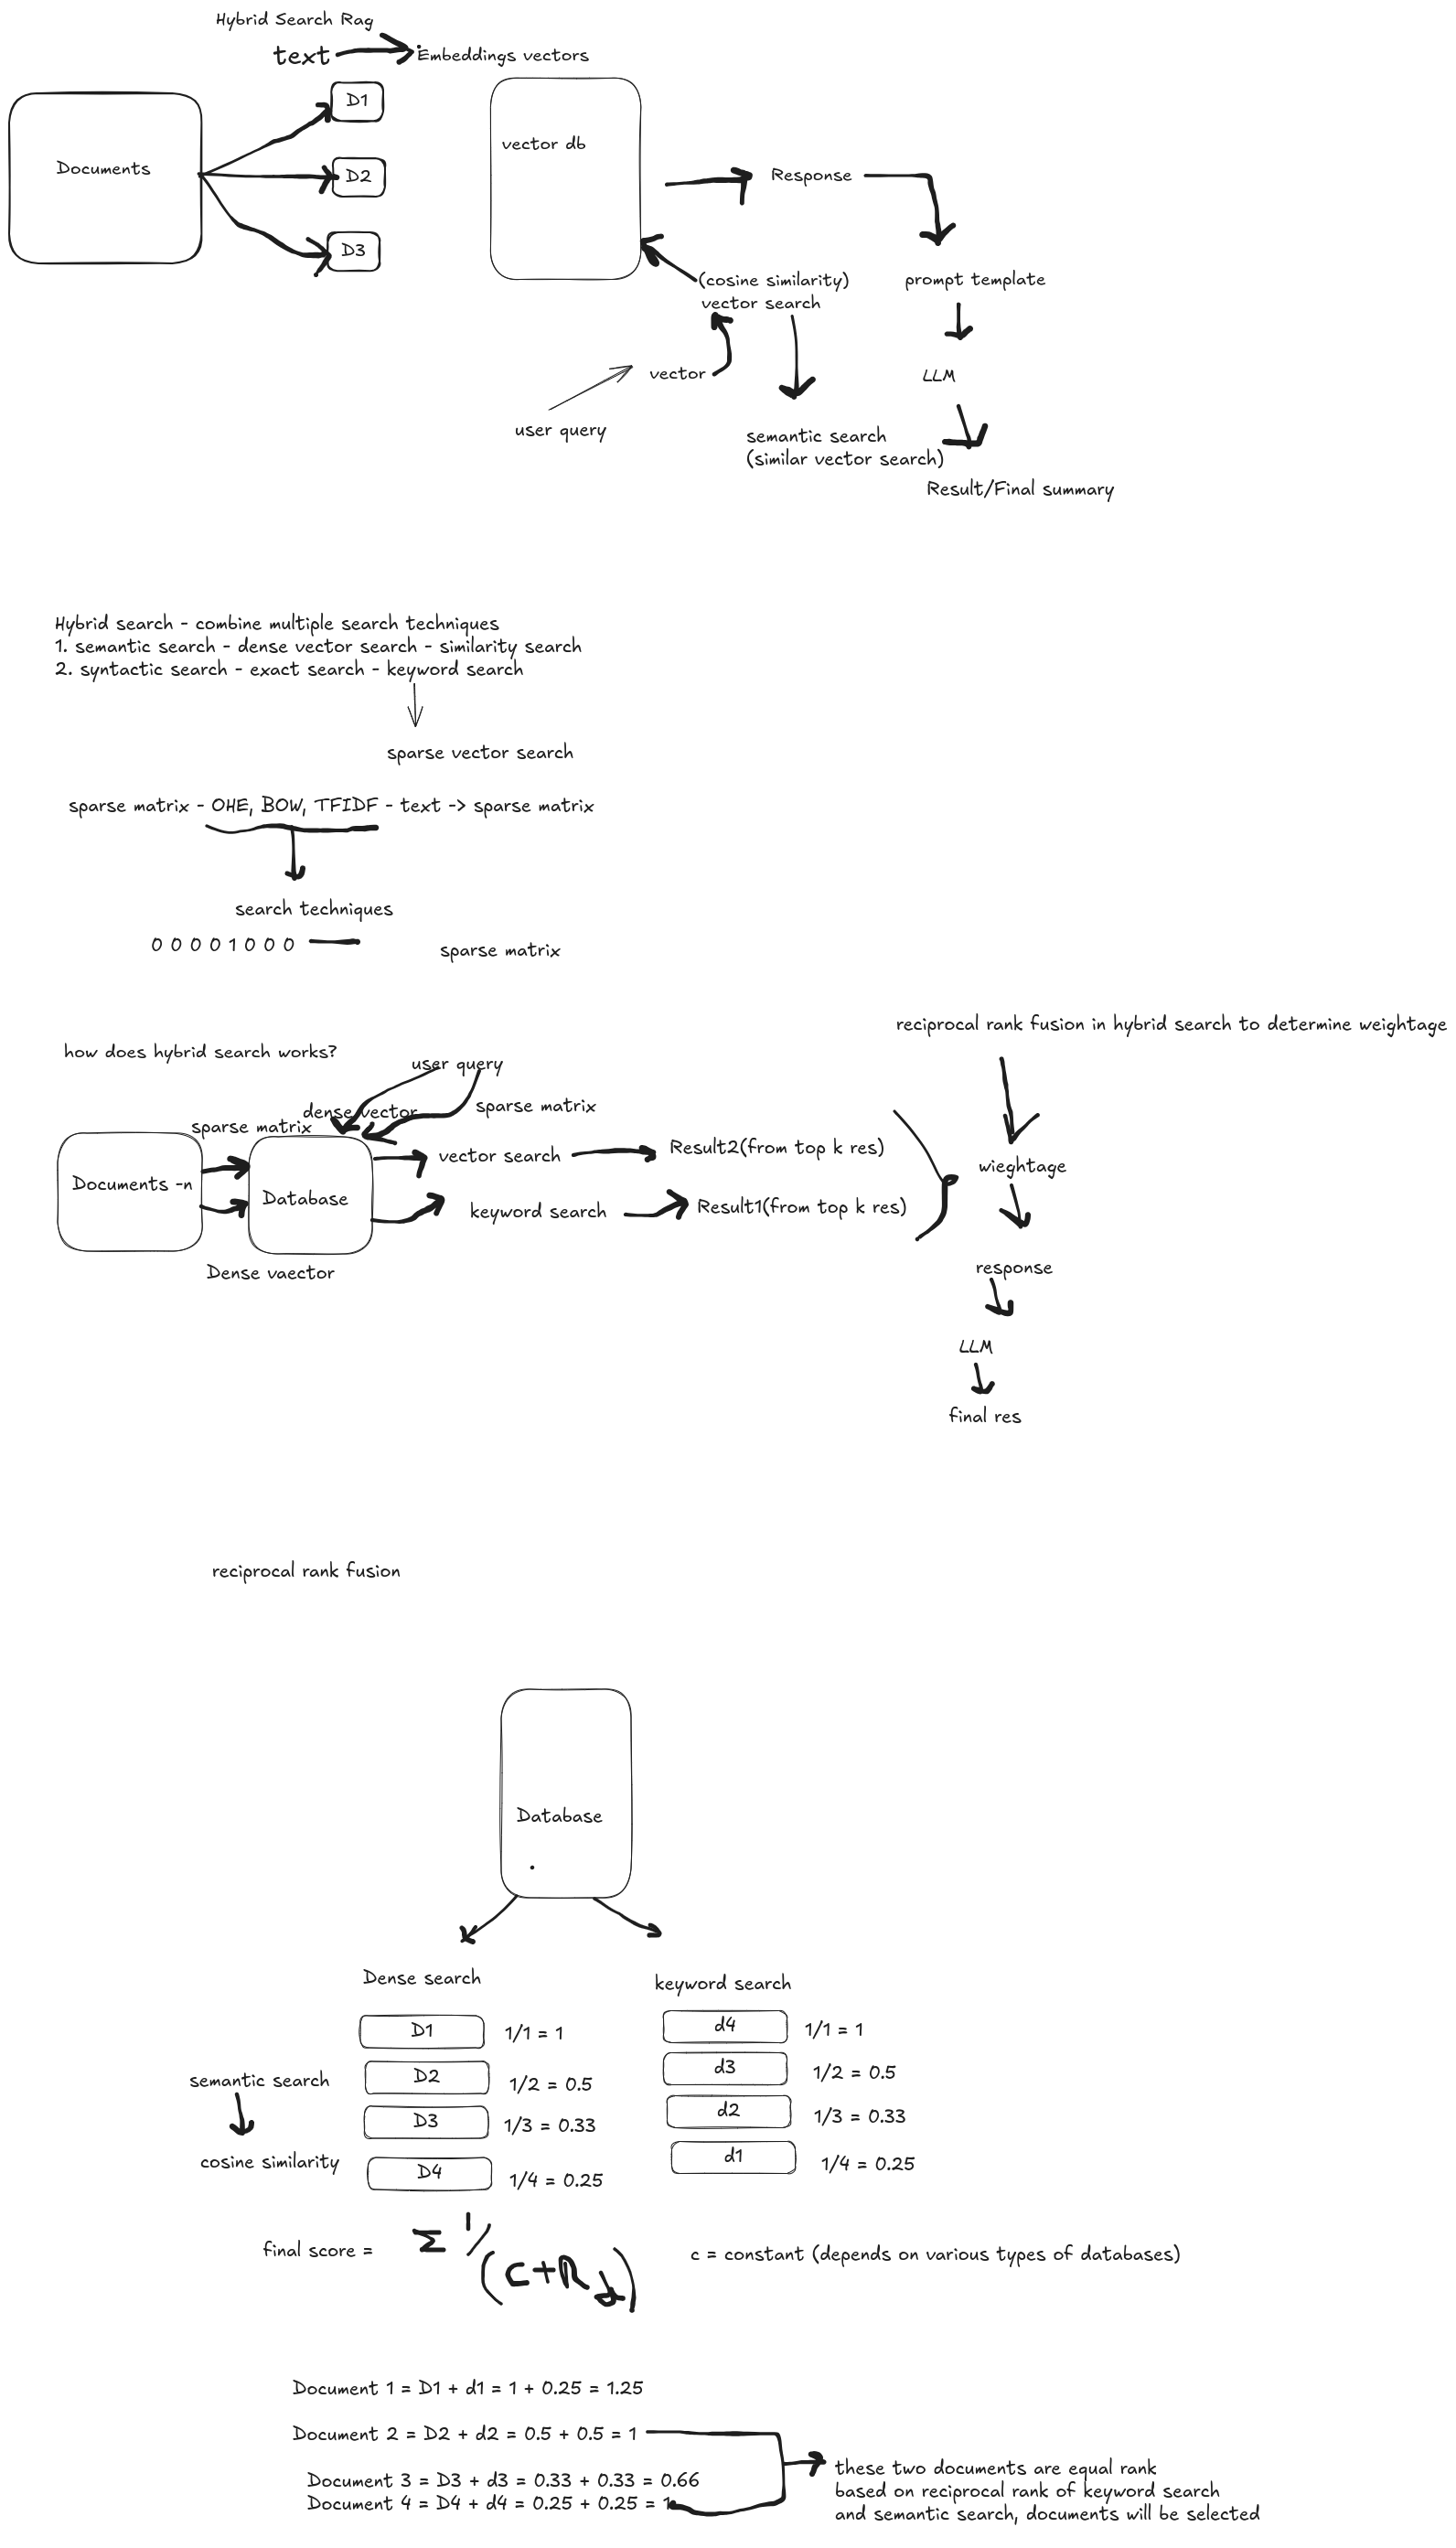

In [ ]:
## Hybrid search using langchain with pinecone vector DB
api_key = "588db9b3-a7ef-4e17-b205-430eaf3b56a7"

from langchain_community.retrievers import PineconeHybridSearchRetriever
import os
from pinecone import Pinecone,ServerlessSpec

index_name="hybrid-serach-langchain-pinecone"

# Initialize pinecone
pc=Pinecone(api_key=api_key)

# create the index
if index_name not in pc.list_indexes().names():
    pc.create_index(
            name=index_name,
            dimension=384, #dimension of dense vector, hugging face embedding converts default into 384 vector
            metric='dotproduct', #sparse value supported for only for dot product
            spec=ServerlessSpec(cloud='aws',region='us-east-1')
            )
index=pc.Index(index_name)
#print(index)

## vector embedding and sparse matrix
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
#print(embeddings)

from pinecone_text.sparse import BM25Encoder
bm25_encoder=BM25Encoder().default() #able to do sparse matrix of any query, by default it uses TFIDF technique
#print(bm25_encoder)

sentences=[
        "In 2023, I visited paris",
        "In 2022, I visited New York",
        "In 2021, I visited New Orleans",
        ]

#tfidf values on these sentences
bm25_encoder.fit(sentences)

#store the values to a json file
bm25_encoder.dump("bm25_values.json")

#load to your BM25Encoder object
bm25_encoder=BM25Encoder().load("bm25_values.json")

#creating retriever
retriever=PineconeHybridSearchRetriever(embeddings=embeddings,sparse_encoder=bm25_encoder,index=index)
retriever.add_texts([
        "In 2023, I visited paris",
        "In 2022, I visited New York",
        "In 2021, I visited New Orleans",
        ]
        )

resp=retriever.invoke("what city did i visit last")
print(resp)

